# iCPET Data Analysis
## Data Cleaning
### Author: Quentin Auster
### Affiliation: University of Pittsburgh Department of Radiology, Beyond Vision, Pu Labs
### Date: May 9, 2023
---

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import os

SEED = 123

In [5]:
np.random.seed(seed=SEED)
rand_day_offset = np.random.randint(1, 10_000)
DATE_OFFSET = pd.Timedelta(rand_day_offset, 'days')

print(f"Date offset: {DATE_OFFSET}")

Date offset: 3583 days 00:00:00


## Clinical hemodynamic data

In [6]:
clinical = pd.read_csv(
	Path('../data/clinical data.csv'),
	parse_dates=True
)

# Clean column names
clinical.columns = (
	clinical.columns
	.str.lower()
	.str.replace(r' +|/', r'_', regex=True)
	.str.replace(r'\(|\)|-', r'', regex=True)
	.str.replace('%_', 'percent_', regex=True)
	.str.replace('%', 'percent_', regex=True)
	.str.replace('1st', 'first')
)

# Make what should be nan values nan values
clinical = clinical.replace('na', np.nan)
clinical = clinical.replace(' ', np.nan)

# Show column names
clinical.columns

Index(['enrollment_id', 'ph_id', 'icpet_id', 'first_icpet', 'pe_study_number',
       'dob', 'age', 'gender', 'race', 'height_cm', 'weight_kg', 'bsa', 'bmi',
       'resolved_pe', 'icpet_study_results', 'normal_study', 'borderline_ph',
       'resting_pah', 'eph', 'resting_hfpef', 'exercise_hfpef',
       'resting_ph_exercise_hfpef', 'exercise_ph_resting_hfpef',
       'deconditioning', 'preload_insufficiency',
       'inappropriate_o2_extraction', 'systemic_htn_response',
       'approached_ventilatory_ceiling', 'surpassed_ventilatory_ceiling',
       'rer', 'vo2_ml_kg_min_at_at', 'peak_vo2_ml_kg_min',
       'estimated_peak_vo2_ml_kg_min', 'percent_vo2_at_at', 'peak_vo2_ml_min',
       'estimated_peak_vo2_ml_min', 'percent_peak_vo2', 'percent_co_achieved',
       've_vco2_slope', 've_vco2_at_at', 'vo2_hr_peak_percent_',
       'vo2_work_slope_output', 'mets', 'peak_measured_mpap_mmhg',
       'peak_calculated_mpap_mmhg', 'peak_pvr_wu', 'peak_arterial_hb',
       'peak_cao2', 'peak_cv

In [7]:
# Set correct dtypes
clinical.enrollment_id = pd.to_numeric(clinical.enrollment_id)
clinical.ph_id = pd.to_numeric(clinical.ph_id)
clinical.first_icpet = pd.to_datetime(clinical.first_icpet)
clinical.pe_study_number = clinical.pe_study_number.str.replace('PE ', 'PE')
clinical.dob = pd.to_datetime(clinical.dob)
clinical.gender = (
	clinical.gender
	.replace({0: 'Female', 1: 'Male'})
	.astype('category')
)
clinical.race = (
	clinical.race
	.replace({0: 'White', 1: 'Non-White', 2: 'Non-White'})
	.astype('category')
)
clinical.resolved_pe = (
	clinical.resolved_pe
	.replace({0: 'Unresolved', 1: 'Resolved'})
	.astype('category')
)
clinical.normal_study = clinical.normal_study.astype('category')
clinical.resting_pah = clinical.resting_pah.astype('category')
clinical.borderline_ph = clinical.borderline_ph.astype('category')
clinical.resting_hfpef = clinical.resting_hfpef.astype('category')
clinical.eph = clinical.eph.astype('category')
clinical.exercise_hfpef = clinical.exercise_hfpef.astype('category')
clinical.resting_ph_exercise_hfpef = clinical.resting_ph_exercise_hfpef.astype('category')
clinical.exercise_ph_resting_hfpef = clinical.exercise_ph_resting_hfpef.astype('category')
clinical.deconditioning = clinical.deconditioning.astype('category')
clinical.preload_insufficiency = clinical.preload_insufficiency.astype('category')
clinical.inappropriate_o2_extraction = clinical.inappropriate_o2_extraction.astype('category')
clinical.systemic_htn_response = clinical.systemic_htn_response.astype('category')
clinical.approached_ventilatory_ceiling = clinical.approached_ventilatory_ceiling.astype('category')
clinical.surpassed_ventilatory_ceiling = clinical.surpassed_ventilatory_ceiling.astype('category')
clinical.peak_pvr_wu = pd.to_numeric(clinical.peak_pvr_wu)
clinical.peak_vo2_ml_min = clinical.peak_vo2_ml_min.astype(np.float64)
clinical.estimated_peak_vo2_ml_min = clinical.estimated_peak_vo2_ml_min.astype(np.float64)
clinical.vo2_hr_peak_percent_  = clinical.vo2_hr_peak_percent_ .astype(np.float64)

# Create categorical column 'normal' where
# normal=1 if % Peak V02 > 80
# normal=0 if % Peak V02 <= 80
# normal=-1 else
clinical['normal'] = -1
clinical.loc[clinical.percent_peak_vo2 > 80, 'normal'] = 1
clinical.loc[clinical.percent_peak_vo2 <= 80, 'normal'] = 0
clinical.normal = clinical.normal.astype('category')

# Mask dates
# Offset dates
clinical['first_icpet_mask'] = clinical.first_icpet + DATE_OFFSET
clinical['dob_mask'] = clinical.dob + DATE_OFFSET
clinical['study_age'] = (clinical.first_icpet_mask - clinical.dob_mask) / pd.Timedelta(365.25, 'days')
clinical['study_date_mask'] = clinical.first_icpet_mask

# Drop irrelevant columns
drop_cols = [
	'icpet_study_results',
	'enrollment_id',
	'ph_id',
	'icpet_id',
	'first_icpet',
	'dob',
	'first_icpet_mask',
]
clinical = clinical.drop(columns=drop_cols).copy()

# Sort values
clinical = clinical.sort_values(by=['pe_study_number', 'study_date_mask'])

# Reset index
clinical = clinical.reset_index(drop=True)

In [8]:
clinical.to_pickle(Path('../data/clinical.pickle'))

In [9]:
clinical = pd.read_pickle(Path('../data/clinical.pickle'))
clinical.head()

,pe_study_number,age,gender,race,height_cm,weight_kg,bsa,bmi,resolved_pe,normal_study,...,peak_cvo2,peak_cavo2,peak_paao2,peak_fick_co,peak_vd_vt,peak_cavo2_a_art_hb,normal,dob_mask,study_age,study_date_mask
0,PE1,49,Male,White,205.70,150.00,2.87,35.500000,Resolved,0,...,6.82500,13.64394,2.905439,15.604727,0.130000,0.885970,0,1977-12-13,49.886379,2027-11-02
1,PE11,37,Female,White,170.00,95.60,2.07,33.070000,Resolved,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1994-01-18,37.026694,2031-01-28
2,PE12,45,Male,White,184.50,111.50,2.34,32.720000,Unresolved,0,...,8.21862,12.46494,19.274715,16.523663,0.205714,0.799035,0,1986-05-02,45.412731,2031-09-30
3,PE14,31,Female,White,167.60,85.55,1.95,30.455938,Unresolved,0,...,7.41872,8.92180,3.302519,18.254263,0.210000,0.737339,0,1997-04-05,31.616701,2028-11-16
4,PE15,18,Female,White,160.02,55.00,1.56,21.430000,Unresolved,0,...,8.58190,12.21672,23.804380,11.849891,0.260000,0.778135,0,2010-08-21,18.699521,2029-05-03


## Cleaning PE/CT scan data

In [10]:
pe = pd.read_csv(
	Path('../data/PE-01-14-2023.csv'),
	parse_dates=True
)

# Clean column names
pe.columns = (
	pe.columns
	.str.lower()
	.str.replace(r' +|/|\+', r'_', regex=True)
	.str.replace(r'\(|\)|-', r'', regex=True)
)

# Rename columns
pe = pe.rename({'patient_name': 'pe_study_number'}, axis=1)

pe.head()

,pe_study_number,patient_id,study_date,age,gender,dob,series_id,slice_number,centralartery,apical_rs1,...,bv10,pb_larger_10,pv_diameter,a_diameter,pv_a,heart_volume,airway_volume,airway_ratio,ild_volume,ild_ratio
0,PE1,HB046619,20140107,045Y,M,19680101,3,174,11.931900,0.399756,...,120.94600,196.3160,52.2725,26.7526,1.95393,0.843713,0.066788,0.011805,0.348080,0.061523
1,PE12,HB046622,20201218,044Y,M,19760101,4,264,0.102822,0.041968,...,160.17800,109.6790,41.5271,21.0758,1.97037,0.632883,0.069840,0.014465,1.200770,0.248702
2,PE12,HB046622,20211203,045Y,M,19760101,2,95,1.391170,0.000000,...,4.53829,120.6390,32.8602,22.9284,1.43317,0.690389,0.047697,0.018161,1.481380,0.564056
3,PE14,HB046616,20181219,031Y,F,19870101,4,111,0.825384,0.000000,...,117.62900,94.9344,33.6370,22.3061,1.50798,0.636081,0.054162,0.010895,0.095727,0.019257
4,PE15,HB046618,20180410,017Y,F,20000101,3,315,0.000000,0.000000,...,120.21400,59.3837,27.3902,17.0060,1.61063,0.437972,0.029738,0.013111,0.515044,0.227086


In [11]:
# Need to mask dates of birth --> offset all dates by random amount determined above

# Convert to datetime
pe.study_date = pd.to_datetime(pe.study_date, format='%Y%m%d')
pe.dob = pd.to_datetime(pe.dob, format='%Y%m%d')

# Offset dates
pe['study_date_mask'] = pe.study_date + DATE_OFFSET
pe['dob_mask'] = pe.dob + DATE_OFFSET

# Calculate age as of study date
pe['study_age'] = (pe.study_date_mask - pe.dob_mask) / pd.Timedelta(365.25, 'days')

# Calculate total clot burden as sum
pe['total_clot_burden'] = (
	pe.centralartery + pe.apical_rs1 + pe.posterior_rs2 +
	pe.anterior_rs3 + pe.lateral_rs4 + pe.medial_rs5 +
	pe.superior_rs6 + pe.medial_basal_rs7 + pe.anterior_basal_rs8 +
	pe.lateral_basal_rs9 + pe.posterior_basal_rs10 +
	pe.apical_ls1 + pe.posterior_ls2 + pe.anterior_ls3 +
	pe.superior_ls4 + pe.inferior_ls5 + pe.superior_ls6 +
	pe.anteromedial_basal_ls7_8 + pe.lateral_basal_ls9 +
	pe.posterior_basal_ls10
)

# Drop original dates and age columns
pe = pe.drop(columns=['study_date', 'dob', 'age'])

In [12]:
# Get cumulative counts for each patient
pe = pe.sort_values(by=['pe_study_number', 'study_date_mask'])
pe['pe_obs'] = pe.groupby('pe_study_number', group_keys=False).cumcount()

# Reset index
pe = pe.reset_index(drop=True)

pe.pe_obs.head()

0    0
1    0
2    1
3    0
4    0
Name: pe_obs, dtype: int64

In [13]:
pe.to_pickle(Path('../data/pe.pickle'))

In [14]:
pe = pd.read_pickle(Path('../data/pe.pickle'))
pe.head()

,pe_study_number,patient_id,gender,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,heart_volume,airway_volume,airway_ratio,ild_volume,ild_ratio,study_date_mask,dob_mask,study_age,total_clot_burden,pe_obs
0,PE1,HB046619,M,3,174,11.931900,0.399756,0.412309,0.326371,0.653708,...,0.843713,0.066788,0.011805,0.348080,0.061523,2023-10-30,1977-10-23,46.017796,18.098190,0
1,PE12,HB046622,M,4,264,0.102822,0.041968,0.000000,0.002098,0.405691,...,0.632883,0.069840,0.014465,1.200770,0.248702,2030-10-10,1985-10-23,44.963723,1.134537,0
2,PE12,HB046622,M,2,95,1.391170,0.000000,0.000000,0.000000,0.114441,...,0.690389,0.047697,0.018161,1.481380,0.564056,2031-09-25,1985-10-23,45.921971,1.505611,1
3,PE14,HB046616,F,4,111,0.825384,0.000000,0.000000,0.000000,0.097104,...,0.636081,0.054162,0.010895,0.095727,0.019257,2028-10-10,1996-10-23,31.964408,1.255416,0
4,PE15,HB046618,F,3,315,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.437972,0.029738,0.013111,0.515044,0.227086,2028-01-31,2009-10-23,18.272416,0.212129,0


## Join Datasets

In [15]:
df = pe.join(
	other=clinical.set_index('pe_study_number'),
	on='pe_study_number',
	how='left',
	lsuffix='_pe',
	rsuffix='_cl',
	validate='m:1'
)

df.head()

,pe_study_number,patient_id,gender_pe,series_id,slice_number,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,...,peak_cvo2,peak_cavo2,peak_paao2,peak_fick_co,peak_vd_vt,peak_cavo2_a_art_hb,normal,dob_mask_cl,study_age_cl,study_date_mask_cl
0,PE1,HB046619,M,3,174,11.931900,0.399756,0.412309,0.326371,0.653708,...,6.82500,13.64394,2.905439,15.604727,0.130000,0.885970,0,1977-12-13,49.886379,2027-11-02
1,PE12,HB046622,M,4,264,0.102822,0.041968,0.000000,0.002098,0.405691,...,8.21862,12.46494,19.274715,16.523663,0.205714,0.799035,0,1986-05-02,45.412731,2031-09-30
2,PE12,HB046622,M,2,95,1.391170,0.000000,0.000000,0.000000,0.114441,...,8.21862,12.46494,19.274715,16.523663,0.205714,0.799035,0,1986-05-02,45.412731,2031-09-30
3,PE14,HB046616,F,4,111,0.825384,0.000000,0.000000,0.000000,0.097104,...,7.41872,8.92180,3.302519,18.254263,0.210000,0.737339,0,1997-04-05,31.616701,2028-11-16
4,PE15,HB046618,F,3,315,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.58190,12.21672,23.804380,11.849891,0.260000,0.778135,0,2010-08-21,18.699521,2029-05-03


In [16]:
# Identify columns to drop
ID_FEAT_TODROP = [
	'pe_study_number',
	'patient_id',
	'series_id',
	'slice_number',
]
NONID_FEAT_TODROP = [
	'gender_pe',
	'dob_mask_pe',
	'dob_mask_cl',
	'study_age_cl',
	'study_date_mask_cl',
	'study_date_mask_pe',
]
FEAT_TODROP = ID_FEAT_TODROP + NONID_FEAT_TODROP
# Check columns to drop are named correctly
assert set(FEAT_TODROP).issubset(set(df.columns))
# Set index to PE number
df.index = df.pe_study_number + '_' + df.pe_obs.apply(str)
# Drop columns
df = df.loc[:, df.columns.difference(FEAT_TODROP)]
# Check shape
print(f"DF All Shape: {df.shape}")
# Check head
df.head()

DF All Shape: (104, 104)


,a_diameter,age,airway_ratio,airway_volume,anterior_basal_rs8,anterior_ls3,anterior_rs3,anteromedial_basal_ls7_8,apical_ls1,apical_rs1,...,ve_vco2_slope,vo2_hr_peak_percent_,vo2_ml_kg_min_at_at,vo2_work_slope_output,volume_bone,volume_intermuscular_fat,volume_muscle,volume_subcutaneous_fat,volume_visceral_fat,weight_kg
PE1_0,26.7526,49.0,0.011805,0.066788,0.201809,0.206637,0.326371,0.06566,0.0,0.399756,...,NaN,45.0,9.6,NaN,2.03983,0.986196,5.87431,6.59418,0.242408,150.00
PE12_0,21.0758,45.0,0.014465,0.069840,0.395899,0.000000,0.002098,0.00000,0.0,0.041968,...,29.557,75.0,10.7,8.038,1.85461,0.904912,6.00182,4.86750,1.988060,111.50
PE12_1,22.9284,45.0,0.018161,0.047697,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,29.557,75.0,10.7,8.038,2.02425,0.629943,8.01657,6.28189,2.443480,111.50
PE14_0,22.3061,31.0,0.010895,0.054162,0.238598,0.000000,0.000000,0.00000,0.0,0.000000,...,32.776,92.0,10.2,7.718,1.68335,0.347496,5.08316,4.88387,0.470233,85.55
PE15_0,17.0060,18.0,0.013111,0.029738,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,28.446,80.0,17.1,NaN,1.16264,0.168386,3.62723,1.53712,0.017716,55.00


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, PE1_0 to PE9_0
Columns: 104 entries, a_diameter to weight_kg
dtypes: category(18), float64(80), int64(6)
memory usage: 72.8+ KB


In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.pairplot(df.select_dtypes(['float', 'int']))
plt.savefig('../figures/num_pairplot.png')

## Detect Outliers

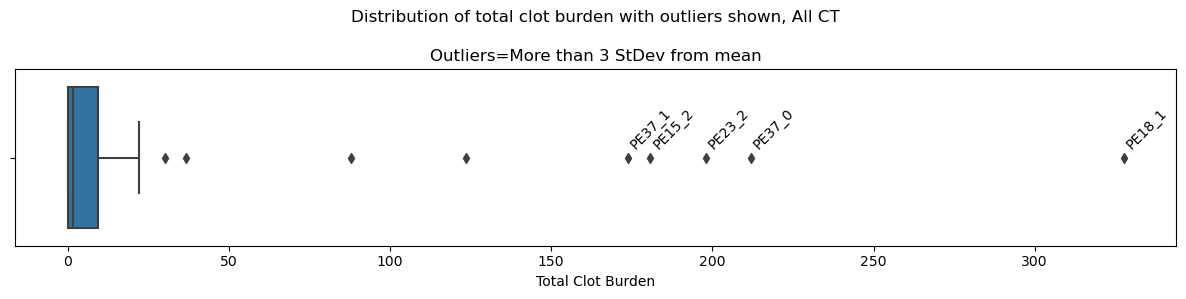

In [40]:
# Calculate z-scores for each data point
z_scores = (df.total_clot_burden - df.total_clot_burden.mean()) / df.total_clot_burden.std()
# Define a threshold for outlier detection
threshold = 3
# Find the indices of outliers
outlier_indices = z_scores[abs(z_scores) > threshold].dropna().index

fig = plt.figure(figsize=(12, 3))
sns.boxplot(data=df, x='total_clot_burden')

for outlier_idx in list(outlier_indices):
	plt.annotate(
		outlier_idx,
		xy=(0, 0), xytext=(df.loc[outlier_idx, 'total_clot_burden'], -0.05), 
		textcoords='data', rotation=45
	)

plt.suptitle('Distribution of total clot burden with outliers shown, All CT')
plt.title('Outliers=More than 3 StDev from mean')
plt.xlabel('Total Clot Burden')

plt.tight_layout()
# plt.savefig('../figures/clot_burden_outliers_all.png')
plt.show()

In [41]:
# # Drop clot burden outliers
df = df.drop(index=outlier_indices)
df.shape

(99, 104)

## Export data

In [42]:
df.to_pickle(Path('../data/df.pickle'))